In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## import libraries 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support, \
    confusion_matrix
# from sklearn.datasets import make_classification
# from sklearn import discriminant_analysis

## funtions run this

In [5]:
def compute_metrics(pred,ground_labels):
    labels_all = ground_labels
    preds_all = list(pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all)
    acc = accuracy_score(labels_all, preds_all)
    confusion_mat = confusion_matrix(labels_all, preds_all)
    # tn, fp, fn, tp = confusiton_mat.ravel()
    out_dict = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusiton_mat': confusion_mat
    }
    return out_dict

## read data

In [263]:
training_labels=pd.read_csv('training_label.csv')
training_values=pd.read_csv('training_values.csv')
data = training_values.merge(training_labels, on='id')

test_=pd.read_csv('test_values.csv')

In [264]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [265]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [266]:
data.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
funder,3635
installer,3655
subvillage,371
public_meeting,3334
scheme_management,3877
scheme_name,28166
permit,3056


In [267]:
test_.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
funder,869
installer,877
subvillage,99
public_meeting,821
scheme_management,969
scheme_name,7092
permit,737


In [268]:
col_null=["funder","installer","subvillage","public_meeting","scheme_management","scheme_name","permit"]
col_drop=[]

In [269]:
data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Final pipeline 

In [209]:
col_drop

['waterpoint_type_group',
 'installer',
 'scheme_name',
 'date_recorded',
 'payment',
 'extraction_type_group',
 'extraction_type_class',
 'management_group',
 'quality_group',
 'quantity_group',
 'source_type',
 'source_class']

In [210]:
col_null

['funder',
 'installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit']

In [270]:
def preprocess(data1,type="train"):
  data=data1.copy(deep=False)
  data['gps_height'].replace(0.0, np.nan, inplace=True)
  data['population'].replace(0.0, np.nan, inplace=True)
  data['amount_tsh'].replace(0.0, np.nan, inplace=True)

  data["gps_height"].fillna(data.groupby(['region', 'district_code'])["gps_height"].transform("mean"), inplace=True)
  data["gps_height"].fillna(data.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
  data["gps_height"].fillna(data["gps_height"].mean(), inplace=True)

  data["population"].fillna(data.groupby(['region', 'district_code'])["population"].transform("median"), inplace=True)
  data["population"].fillna(data.groupby(['region'])["population"].transform("median"), inplace=True)
  data["population"].fillna(data["population"].median(), inplace=True)

  data["amount_tsh"].fillna(data.groupby(['region', 'district_code'])["amount_tsh"].transform("median"), inplace=True)
  data["amount_tsh"].fillna(data.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
  data["amount_tsh"].fillna(data["amount_tsh"].median(), inplace=True)

  data['longitude'].replace(0.0, np.nan, inplace=True)

  data["latitude"].fillna(data.groupby(['region', 'district_code'])["latitude"].transform("mean"), inplace=True)
  data["latitude"].fillna(data.groupby(['region'])["latitude"].transform("mean"), inplace=True)

  data["longitude"].fillna(data.groupby(['region', 'district_code'])["longitude"].transform("mean"), inplace=True)
  data["longitude"].fillna(data.groupby(['region'])["longitude"].transform("mean"), inplace=True)

  data['construction_year'].replace(0.0, np.nan, inplace=True)

  data["construction_year"].fillna(data.groupby(['region', 'district_code'])["construction_year"].transform("median"), inplace=True)
  data["construction_year"].fillna(data.groupby(['region'])["construction_year"].transform("median"), inplace=True)
  data["construction_year"].fillna(data.groupby(['district_code'])["construction_year"].transform("median"), inplace=True)
  data["construction_year"].fillna(data["construction_year"].median(), inplace=True)

  data['date_recorded'] = pd.to_datetime(data['date_recorded'])
  data['operational_year'] = data.date_recorded.dt.year - data.construction_year
  data['operational_month'] = data.operational_year*12


  # data["recorded_year"] =data.date_recorded.dt.year

  data["funder"].fillna("other", inplace=True)
  data["scheme_management"].fillna("other", inplace=True)
  data["installer"].fillna("other", inplace=True)

  data["subvillage"].fillna("other", inplace=True)
  data["public_meeting"].fillna(data["public_meeting"].mode()[0], inplace=True)
  data["permit"].fillna(data["permit"].mode()[0], inplace=True)

  drop_col=['waterpoint_type_group',
            'installer',
            # 'ward',
            # 'lga',
            'scheme_name',
            'date_recorded',
            'payment',
            'extraction_type_group',
            'extraction_type_class',
            'management_group',
            'quality_group',
            'quantity_group',
            # 'wpt_name',
            # 'num_private',
            # 'subvillage',
            # 'region_code',
            'recorded_by',
            'source_type',
            'source_class',
            # "recorded_year"      
            # 'public_meeting',
            # 'permit',
            #   "funder"
            ]

  data.drop(columns=drop_col,inplace=True)

  return data

In [298]:
def encode(data1,type="train"):
  data=data1.copy(deep=False)

  # obj_column=['basin', 'region', 'scheme_management', 'extraction_type',
  #      'management', 'payment_type', 'water_quality', 'quantity',
  #      'source', 'waterpoint_type']

  obj_column = data.columns[data.dtypes == "object"].values
  # if type == "train":
  #   print("train")
  #   categorical_encoding={ 
  #     "basin" : ['Lake Nyasa' ,'Lake Victoria' ,'Pangani', 'Ruvuma / Southern Coast','Internal' ,'Lake Tanganyika' ,'Wami / Ruvu' ,'Rufiji' ,'Lake Rukwa']
  #     ,"region" : ['Iringa', 'Mara', 'Manyara', 'Mtwara' ,'Kagera', 'Tanga' ,'Shinyanga' ,'Tabora','Pwani', 'Ruvuma' ,'Kilimanjaro', 'Rukwa' ,'Mwanza' ,'Kigoma', 'Lindi' ,'Dodoma','Arusha', 'Mbeya' ,'Singida' ,'Morogoro', 'Dar es Salaam']
  #     ,"scheme_management" : ['VWC', 'Other', 'other' ,'Private operator', 'WUG', 'Water Board', 'WUA','Water authority', 'Company' ,'Parastatal', 'Trust', 'SWC' ,'None']
  #     ,"extraction_type" : ['gravity' ,'submersible', 'swn 80', 'nira/tanira' ,'india mark ii', 'other','ksb' ,'mono' ,'windmill' ,'afridev' ,'other - rope pump', 'india mark iii', 'other - swn 81' ,'other - play pump' ,'cemo', 'climax' ,'walimi','other - mkulima/shinyanga']
  #     ,"management" : ['vwc' ,'wug' ,'other' ,'private operator' ,'water board' ,'wua', 'company','water authority', 'parastatal' ,'unknown' ,'other - school', 'trust']
  #     ,"payment_type" : ['annually' ,'never pay', 'per bucket', 'unknown' ,'on failure', 'other','monthly']
  #     ,"water_quality" : ['soft', 'salty', 'milky' ,'unknown', 'fluoride', 'coloured' ,'salty abandoned','fluoride abandoned']
  #     ,"quantity" : ['enough', 'insufficient', 'dry' ,'seasonal' ,'unknown']
  #     ,"source" : ['spring' ,'rainwater harvesting' ,'dam' ,'machine dbh', 'other','shallow well', 'river' ,'hand dtw' ,'lake' ,'unknown']
  #     ,"waterpoint_type" : ['communal standpipe' ,'communal standpipe multiple', 'hand pump', 'other','improved spring', 'cattle trough' ,'dam']
  #     ,"status_group" : ['functional' ,'non functional' ,'functional needs repair']
  #   } 
  #   obj_column.append("status_group")
  # else:
  #   print("test")
  #   categorical_encoding={ 
  #   "basin" : ['Lake Nyasa' ,'Lake Victoria' ,'Pangani', 'Ruvuma / Southern Coast','Internal' ,'Lake Tanganyika' ,'Wami / Ruvu' ,'Rufiji' ,'Lake Rukwa']
  #   ,"region" : ['Iringa', 'Mara', 'Manyara', 'Mtwara' ,'Kagera', 'Tanga' ,'Shinyanga' ,'Tabora','Pwani', 'Ruvuma' ,'Kilimanjaro', 'Rukwa' ,'Mwanza' ,'Kigoma', 'Lindi' ,'Dodoma','Arusha', 'Mbeya' ,'Singida' ,'Morogoro', 'Dar es Salaam']
  #   ,"scheme_management" : ['VWC', 'Other', 'other' ,'Private operator', 'WUG', 'Water Board', 'WUA','Water authority', 'Company' ,'Parastatal', 'Trust', 'SWC' ,'None']
  #   ,"extraction_type" : ['gravity' ,'submersible', 'swn 80', 'nira/tanira' ,'india mark ii', 'other','ksb' ,'mono' ,'windmill' ,'afridev' ,'other - rope pump', 'india mark iii', 'other - swn 81' ,'other - play pump' ,'cemo', 'climax' ,'walimi','other - mkulima/shinyanga']
  #   ,"management" : ['vwc' ,'wug' ,'other' ,'private operator' ,'water board' ,'wua', 'company','water authority', 'parastatal' ,'unknown' ,'other - school', 'trust']
  #   ,"payment_type" : ['annually' ,'never pay', 'per bucket', 'unknown' ,'on failure', 'other','monthly']
  #   ,"water_quality" : ['soft', 'salty', 'milky' ,'unknown', 'fluoride', 'coloured' ,'salty abandoned','fluoride abandoned']
  #   ,"quantity" : ['enough', 'insufficient', 'dry' ,'seasonal' ,'unknown']
  #   ,"source" : ['spring' ,'rainwater harvesting' ,'dam' ,'machine dbh', 'other','shallow well', 'river' ,'hand dtw' ,'lake' ,'unknown']
  #   ,"waterpoint_type" : ['communal standpipe' ,'communal standpipe multiple', 'hand pump', 'other','improved spring', 'cattle trough' ,'dam']
  #   # ,"status_group" : ['functional' ,'non functional' ,'functional needs repair']
  # } 
    
  
  for i in obj_column:
    if i!="split":
      print(i,)
      le = preprocessing.LabelEncoder()
      # le.fit(categorical_encoding[i])
      data[i]=le.fit_transform(data[i])

  # for i in obj_column:
  #   data[i]=data[i].apply(str.lower)

  # data=pd.get_dummies(data , columns=obj_column, prefix=obj_column)

  return data

In [271]:
data_df=preprocess(data,type="train")
# data_df=data

In [290]:
data_df.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude',
       'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'status_group',
       'operational_year', 'operational_month'],
      dtype='object')

In [273]:
cat_features=data_df.columns[data_df.dtypes == "object"].values
cat_features

array(['funder', 'wpt_name', 'basin', 'subvillage', 'region', 'lga',
       'ward', 'scheme_management', 'extraction_type', 'management',
       'payment_type', 'water_quality', 'quantity', 'source',
       'waterpoint_type', 'status_group'], dtype=object)

In [274]:
data_df.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts


In [275]:
test_df=preprocess(test_,type="test")
# test_df=test_

In [276]:
test_df.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts


In [277]:
cat_features=np.setdiff1d(cat_features,np.array(["id","status_group"]))
cat_features
# ["subvillage","public_meeting","scheme_name","permit"]

array(['basin', 'extraction_type', 'funder', 'lga', 'management',
       'payment_type', 'quantity', 'region', 'scheme_management',
       'source', 'subvillage', 'ward', 'water_quality', 'waterpoint_type',
       'wpt_name'], dtype=object)

In [278]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    data_df.drop(columns=["status_group","id"]),
    data_df["status_group"],
    test_size=0.3,
    shuffle=True,
    stratify=data["status_group"],
    random_state=45)
# ,"date_recorded","subvillage","public_meeting","scheme_name","permit"

#### catboost

In [243]:
%%capture
!pip3 install catboost

In [279]:
from catboost import Pool, CatBoostClassifier

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_val,
                    label=y_val,
                    cat_features=cat_features)
modelCat = CatBoostClassifier(loss_function='MultiClass')

In [280]:
modelCat.fit(train_dataset,verbose=False)
modelCat.get_best_score()

{'learn': {'MultiClass': 0.43087749388058416}}

In [282]:
y_pred=modelCat.predict(eval_dataset)
d=compute_metrics(y_pred,y_val)
d

{'accuracy': 0.8071268237934904, 'confusiton_mat': array([[8762,  161,  755],
        [ 718,  391,  186],
        [1531,   86, 5230]]), 'f1': array([0.84702016, 0.40455251, 0.80350284]), 'precision': array([0.7957497 , 0.61285266, 0.84751256]), 'recall': array([0.90535235, 0.3019305 , 0.76383818])}

In [284]:
featurs = modelCat.feature_names_
print(featurs)

['amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'management', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'operational_year', 'operational_month']


In [285]:
test_df["status_group"]=modelCat.predict(test_df[featurs])

In [287]:
test_df[["id","status_group"]].to_csv("submission4.csv",index=False)

#### adaboost

In [291]:
# data_df["split"]="train"
# test_df["split"]="test"

In [297]:
# dataframe = pd.concat([data_df, test_df], axis=0)

In [299]:
# dataframe_df=encode(dataframe)

funder
wpt_name
basin
subvillage
region
lga
ward
scheme_management
extraction_type
management
payment_type
water_quality
quantity
source
waterpoint_type
status_group


In [300]:
# dataframe_df["status_group"]=data_df["status_group"]

In [301]:
# dataframe_df.split=="train"

0         True
1         True
2         True
3         True
4         True
         ...  
14845    False
14846    False
14847    False
14848    False
14849    False
Name: split, Length: 74250, dtype: bool

In [309]:
# data_df=dataframe_df.loc[dataframe_df.split=="train"].drop(columns=["split"])
# test_df=dataframe_df.loc[dataframe_df.split=="test"].drop(columns=["status_group","split"])

In [310]:
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(
#     data_df.drop(columns=["status_group","id"]),
#     data_df["status_group"],
#     test_size=0.3,
#     shuffle=True,
#     stratify=data["status_group"],
#     random_state=45)
# # ,"date_recorded","subvillage","public_meeting","scheme_name","permit"

In [311]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=14), n_estimators=100,algorithm="SAMME.R", learning_rate=0.0001)
# ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=14,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

In [312]:
# y_pred=ada_clf.predict(X_val)
# d=compute_metrics(y_pred,y_val)

In [314]:
# print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu'))  
# print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy']))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu
0.762	0.478	0.862	0.262	0.809	0.338	0.759


# Experimenting with data

## plots and exploring data (No need to rerun)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

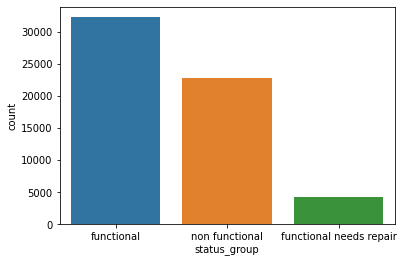

In [102]:
plt.figure()
sns.countplot(data.status_group)
data.status_group.value_counts()

In [104]:
data.groupby(['waterpoint_type', 'waterpoint_type_group']).size() 

waterpoint_type              waterpoint_type_group
cattle trough                cattle trough              116
communal standpipe           communal standpipe       28522
communal standpipe multiple  communal standpipe        6103
dam                          dam                          7
hand pump                    hand pump                17488
improved spring              improved spring            784
other                        other                     6380
dtype: int64

In [105]:
col_drop.append("waterpoint_type_group")

In [120]:
data.installer.value_counts()


DWE                  17402
Government            1825
RWE                   1206
Commu                 1060
DANIDA                1050
                     ...  
HOWARD HUMFREYS          1
Ministry of water        1
LOMOLOKI                 1
CCP                      1
Kidika                   1
Name: installer, Length: 2145, dtype: int64

In [121]:
data.funder.value_counts()


Government Of Tanzania      9084
Danida                      3114
Hesawa                      2202
Rwssp                       1374
World Bank                  1349
                            ... 
Rudri                          1
Engineers Without Border       1
Kalitesi                       1
Redet                          1
Mwalimu Muhenza                1
Name: funder, Length: 1897, dtype: int64

In [116]:
data.groupby(['installer', 'funder','status_group']).size()

installer       funder                  status_group           
-               Government Of Tanzania  functional                   1
                                        non functional               1
                Kalebejo Parish         functional                   1
0               0                       functional                 445
                                        functional needs repair      3
                                                                  ... 
wizara ya maji  Serikali                functional                   2
world           World Bank              functional needs repair      1
                                        non functional               3
world banks     World Bank              non functional               1
world vision    World Vision            functional                   1
Length: 5188, dtype: int64

In [117]:
col_drop.append("installer")

In [118]:
data.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [119]:
data.ward.value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Kitete         1
Burungura      1
Simbay         1
Mkumbi         1
Kapilula       1
Name: ward, Length: 2092, dtype: int64

In [122]:
print(data.groupby(['lga', 'ward','status_group']).size() )

lga           ward     status_group           
Arusha Rural  Bangata  functional                 21
                       functional needs repair     2
                       non functional             10
              Bwawani  functional                 12
                       non functional             25
                                                  ..
Uyui          Ufuluma  non functional             10
              Upuge    functional                  7
                       non functional             11
              Usagali  functional                  8
                       non functional             17
Length: 5070, dtype: int64


In [ ]:
# col_drop.append("ward")
# col_drop.append("lga")

In [123]:
data.scheme_name.value_counts()

K                       682
None                    644
Borehole                546
Chalinze wate           405
M                       400
                       ... 
Kisa                      1
Bl Aziz water supply      1
Kwam                      1
Mlima wa Nyasho           1
Sukuro pipe scheme        1
Name: scheme_name, Length: 2696, dtype: int64

In [124]:
data.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [125]:
data.groupby(['scheme_management', 'scheme_name']).size() 


scheme_management  scheme_name              
Company            BFFS                           1
                   Bagamoyo Wate                 60
                   Bagamoyo wate                210
                   Borehole                       1
                   Borehole drilling project      1
                                               ... 
Water authority    Yongoma                       16
                   Zepalama                       5
                   no scheme                      9
                   pump                           2
                   water supply at Kalebejo       1
Length: 3077, dtype: int64

In [126]:
col_drop.append("scheme_name")

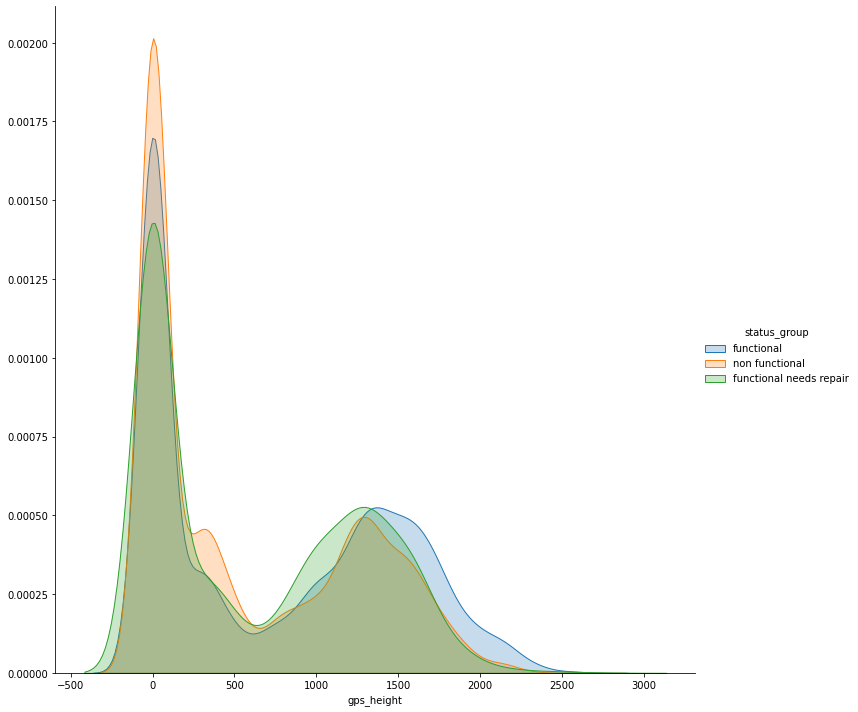

In [128]:
sns.FacetGrid(data, hue='status_group',height=10).map(sns.kdeplot, 'gps_height', shade=True).add_legend()

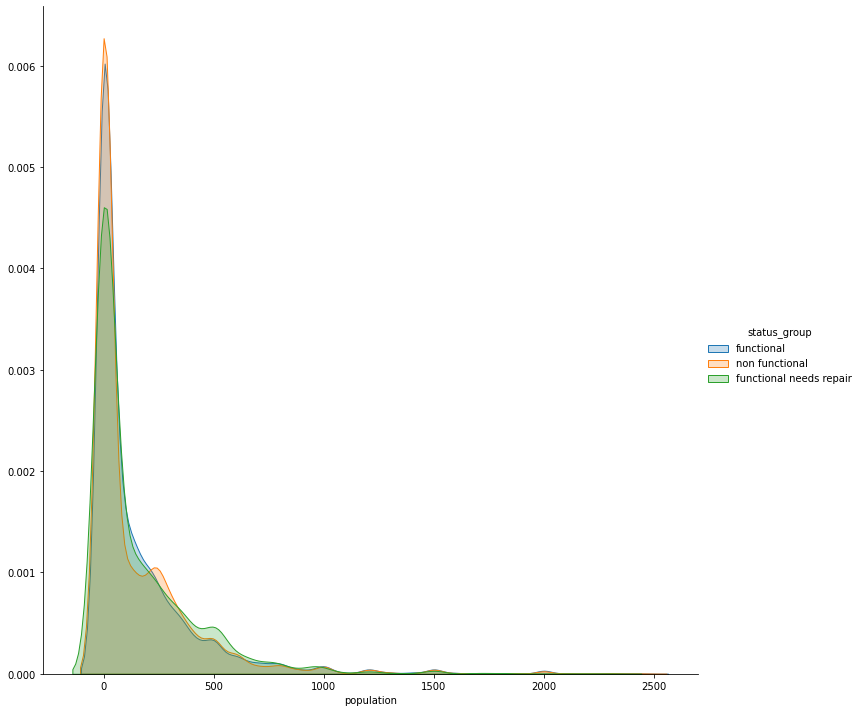

In [136]:
sns.FacetGrid(data.loc[data.population<2500], hue='status_group',height=10).map(sns.kdeplot, 'population', shade=True).add_legend()

In [134]:
test_.loc[test_.population>2500]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
360,69131,50.0,2013-01-23,Anglican Church,383,Anglikana,38.580871,-10.628516,Darajani,0,Ruvuma / Southern Coast,Mkwajuni,Mtwara,90,33,Masasi,Namatutwe,3000,True,GeoData Consultants Ltd,VWC,NaN,True,2009,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
417,46606,0.0,2013-02-25,Hesawa,1477,HESAWA,34.613878,-1.737123,Peter Ntera,0,Lake Victoria,Kwanina,Mara,20,2,Serengeti,Rung'bure,4000,NaN,GeoData Consultants Ltd,Other,NaN,True,1995,swn 80,swn 80,handpump,wug,user-group,unknown,unknown,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
548,49863,20.0,2011-02-24,Msikiti,-7,Priva,38.978975,-7.954094,Msikitini,5,Rufiji,Kingwande,Pwani,60,53,Rufiji,Ikwiriri,3226,True,GeoData Consultants Ltd,Private operator,NaN,False,2009,mono,mono,motorpump,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
650,74223,150.0,2011-08-11,Uwamalu,534,Uwamalu,37.627511,-6.745134,Kwa Bago,0,Wami / Ruvu,Majengo Mapya,Morogoro,5,5,Morogoro Urban,Kihonda,4000,True,GeoData Consultants Ltd,VWC,Uwamalu,True,2008,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
659,23175,30.0,2011-02-24,Private,-48,Priva,38.976944,-7.951810,Mwangaya,5,Rufiji,Malepea,Pwani,60,53,Rufiji,Ikwiriri,3226,False,GeoData Consultants Ltd,VWC,NaN,False,2007,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14448,12657,0.0,2013-01-23,Kuwasa,829,KUWASA,29.664855,-4.867519,Kwa Siwazui,0,Lake Tanganyika,Masanga,Kigoma,16,4,Kigoma Urban,Buhanda businde,2554,False,GeoData Consultants Ltd,Other,Mradi wa maji wa buhanda,True,1980,other,other,other,other,other,never pay,never pay,soft,good,dry,dry,lake,river/lake,surface,communal standpipe multiple,communal standpipe
14481,22127,10.0,2013-07-03,Germany Republi,898,CES,37.110094,-3.409521,Area 16 Namba,0,Pangani,Parestina,Kilimanjaro,3,5,Hai,Masama Rundugai,7600,True,GeoData Consultants Ltd,Water Board,Losaa-Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
14500,52658,500.0,2012-10-30,Jika,1204,Jika,34.091829,-1.429240,Namba Mlili,0,Lake Victoria,Kisumwa,Mara,20,6,Rorya,Kisumwa,4500,True,GeoData Consultants Ltd,NaN,NaN,True,2011,afridev,afridev,handpump,vwc,user-group,pay monthly,monthly,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14652,34837,0.0,2013-01-17,Oxfarm,1170,OXFARM,30.324773,-3.858649,Bungwe,0,Lake Tanganyika,Kariba,Kigoma,16,2,Kasulu,Kitanga,4520,True,GeoData Consultants Ltd,Water authority,NaN,False,1994,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


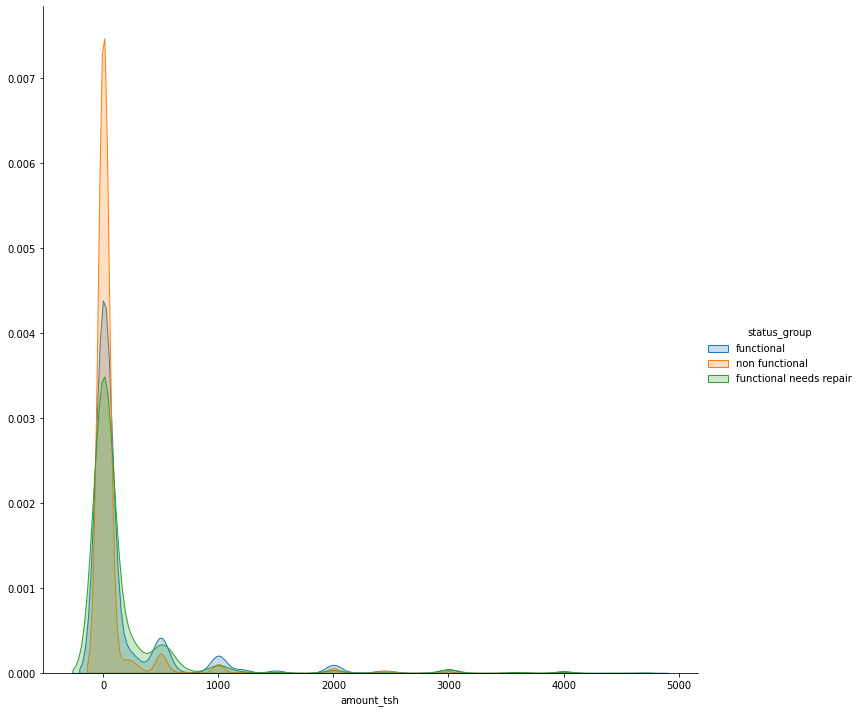

In [145]:
sns.FacetGrid(data.loc[data.amount_tsh<5000], hue='status_group',height=10).map(sns.kdeplot, 'amount_tsh', shade=True).add_legend()

In [137]:
data.amount_tsh.describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [146]:
data.loc[data.amount_tsh>5000].shape

(470, 41)

In [147]:
data['gps_height'].replace(0.0, np.nan, inplace=True)
data['population'].replace(0.0, np.nan, inplace=True)
data['amount_tsh'].replace(0.0, np.nan, inplace=True)

In [148]:
data["gps_height"].fillna(data.groupby(['region', 'district_code'])["gps_height"].transform("mean"), inplace=True)
data["gps_height"].fillna(data.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
data["gps_height"].fillna(data["gps_height"].mean(), inplace=True)

data["population"].fillna(data.groupby(['region', 'district_code'])["population"].transform("median"), inplace=True)
data["population"].fillna(data.groupby(['region'])["population"].transform("median"), inplace=True)
data["population"].fillna(data["population"].median(), inplace=True)

data["amount_tsh"].fillna(data.groupby(['region', 'district_code'])["amount_tsh"].transform("median"), inplace=True)
data["amount_tsh"].fillna(data.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
data["amount_tsh"].fillna(data["amount_tsh"].median(), inplace=True)

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

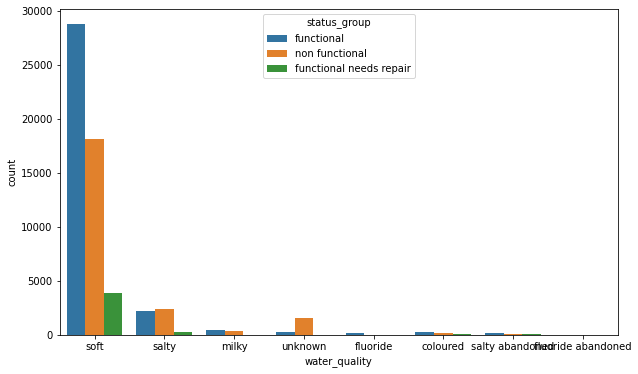

In [149]:
plt.figure(figsize=(10,6))
sns.countplot(data=data,x='water_quality',hue='status_group')
data.water_quality.value_counts()

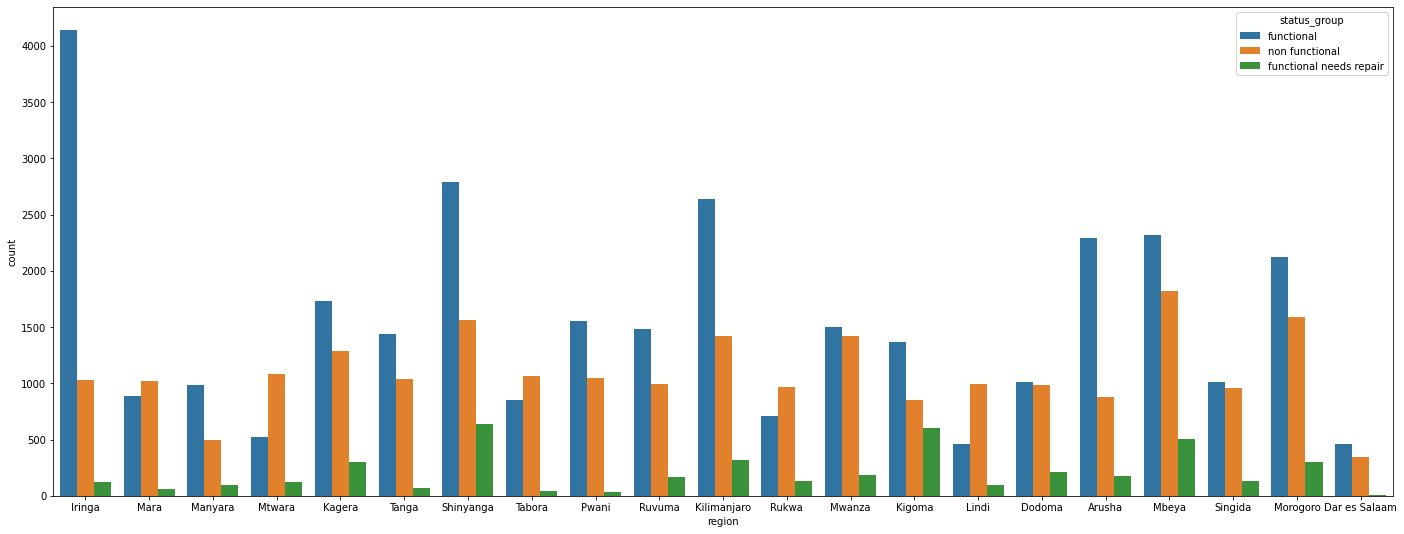

In [150]:
#looking at regions
plt.figure(figsize=(24, 9))

sns.countplot(data=data,x='region',hue='status_group')

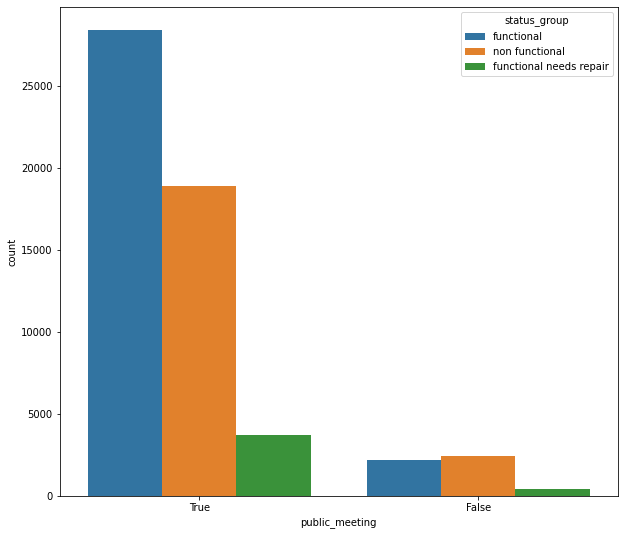

In [151]:
plt.figure(figsize=(10, 9))

sns.countplot(data=data,x='public_meeting',hue='status_group')

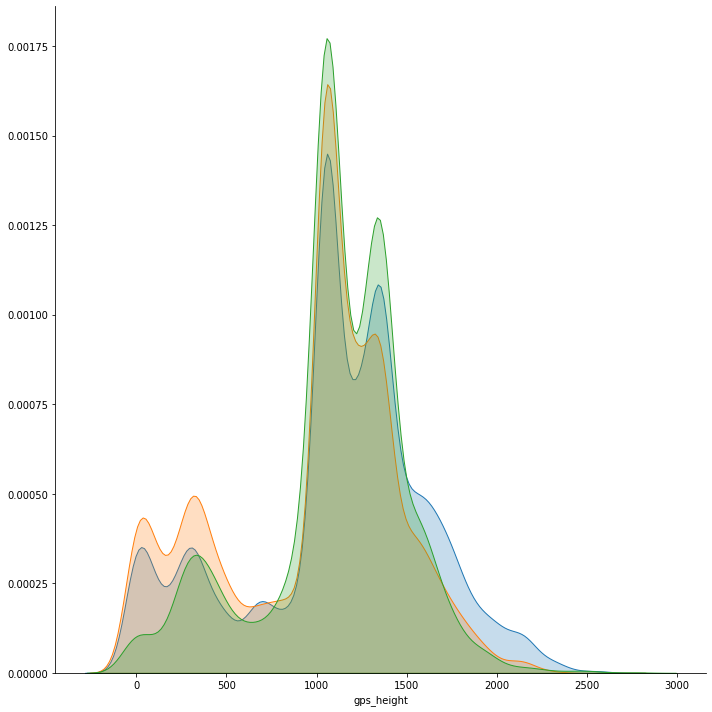

In [153]:
sns.FacetGrid(data, hue='status_group',height=10).map(sns.kdeplot, 'gps_height', shade=True)

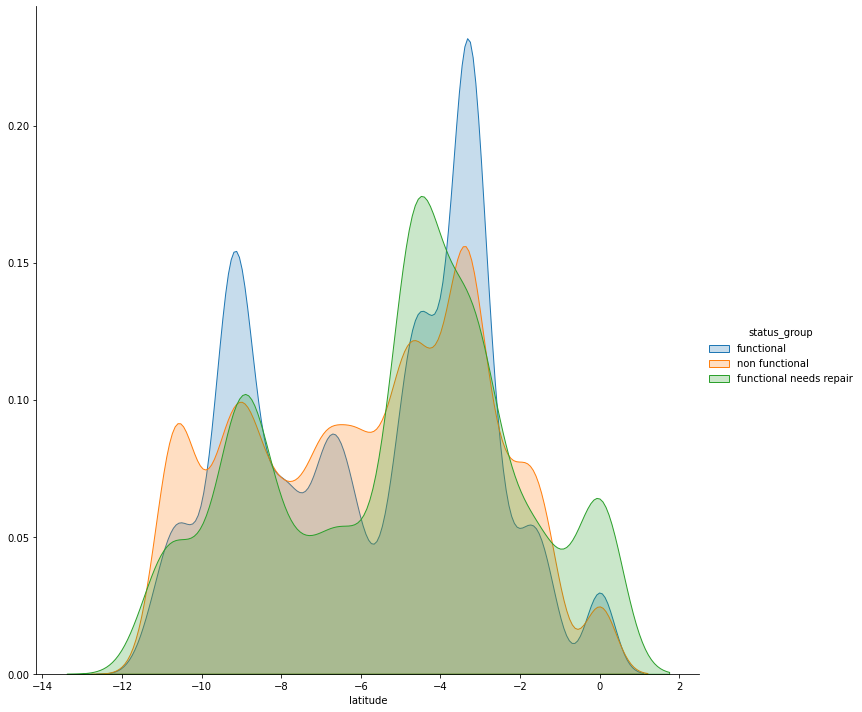

In [154]:
sns.FacetGrid(data, hue='status_group',height=10).map(sns.kdeplot, 'latitude', shade=True).add_legend()

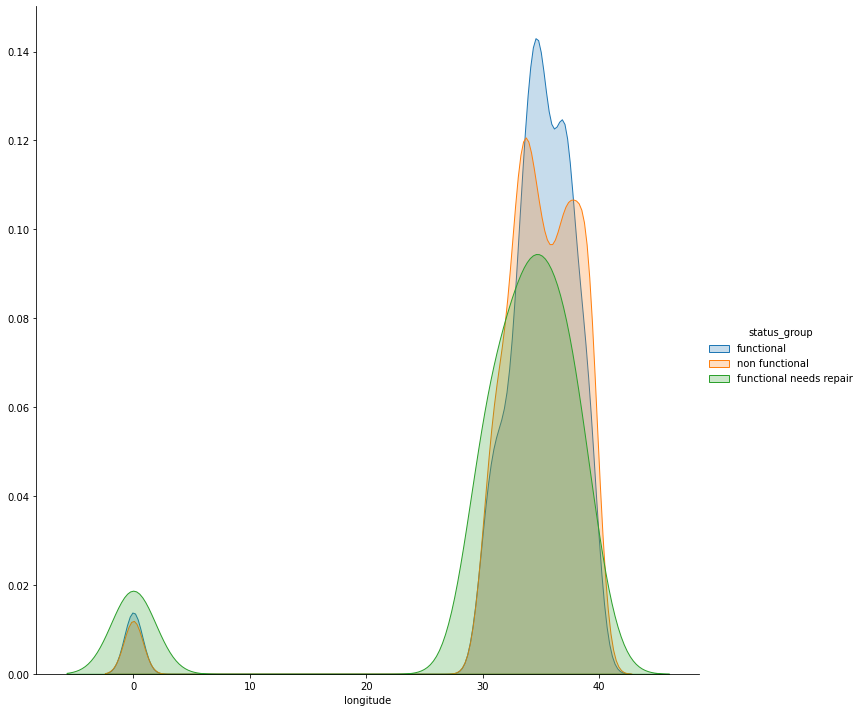

In [155]:
sns.FacetGrid(data, hue='status_group',height=10).map(sns.kdeplot, 'longitude', shade=True).add_legend()

In [156]:
data['longitude'].replace(0.0, np.nan, inplace=True)

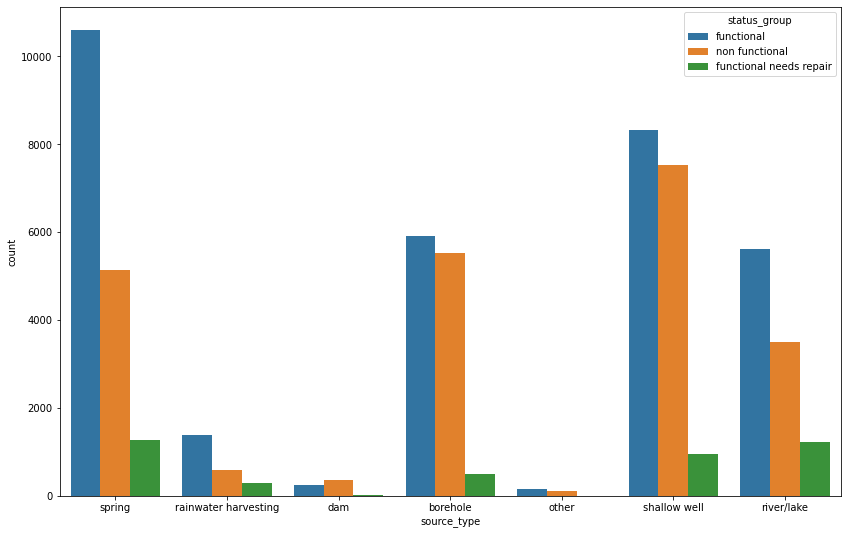

In [159]:
plt.figure(figsize=(14, 9))

sns.countplot(data=data,x='source_type',hue='status_group')

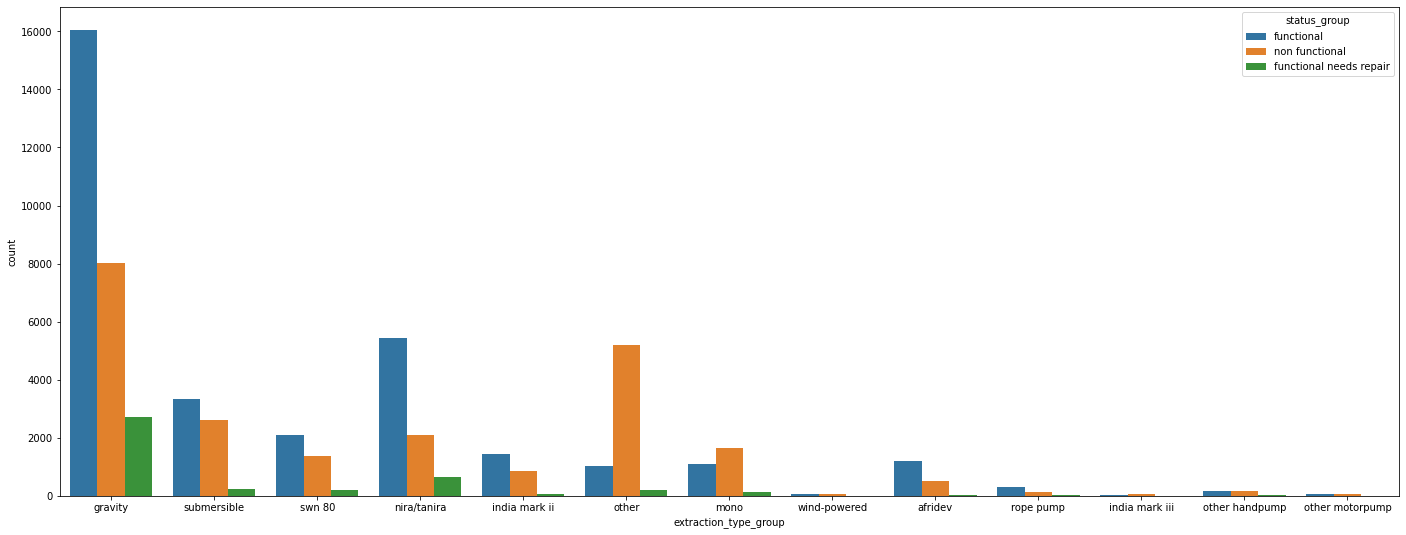

In [160]:
plt.figure(figsize=(24, 9))

sns.countplot(data=data,x='extraction_type_group',hue='status_group')

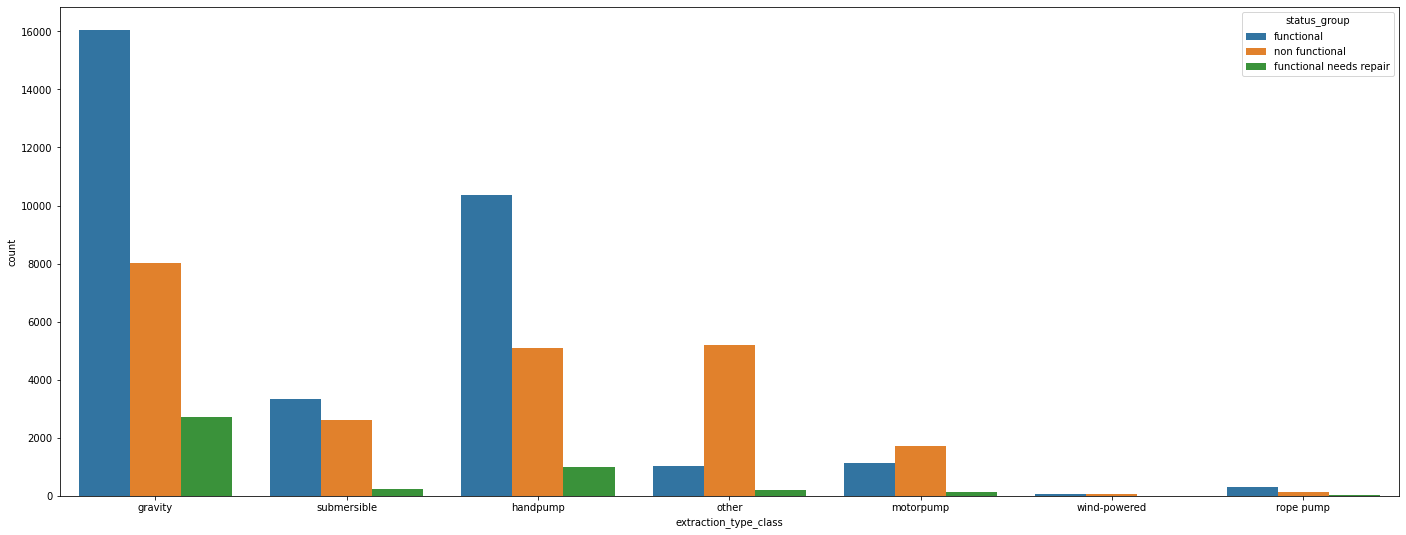

In [161]:
plt.figure(figsize=(24, 9))

sns.countplot(data=data,x='extraction_type_class',hue='status_group')

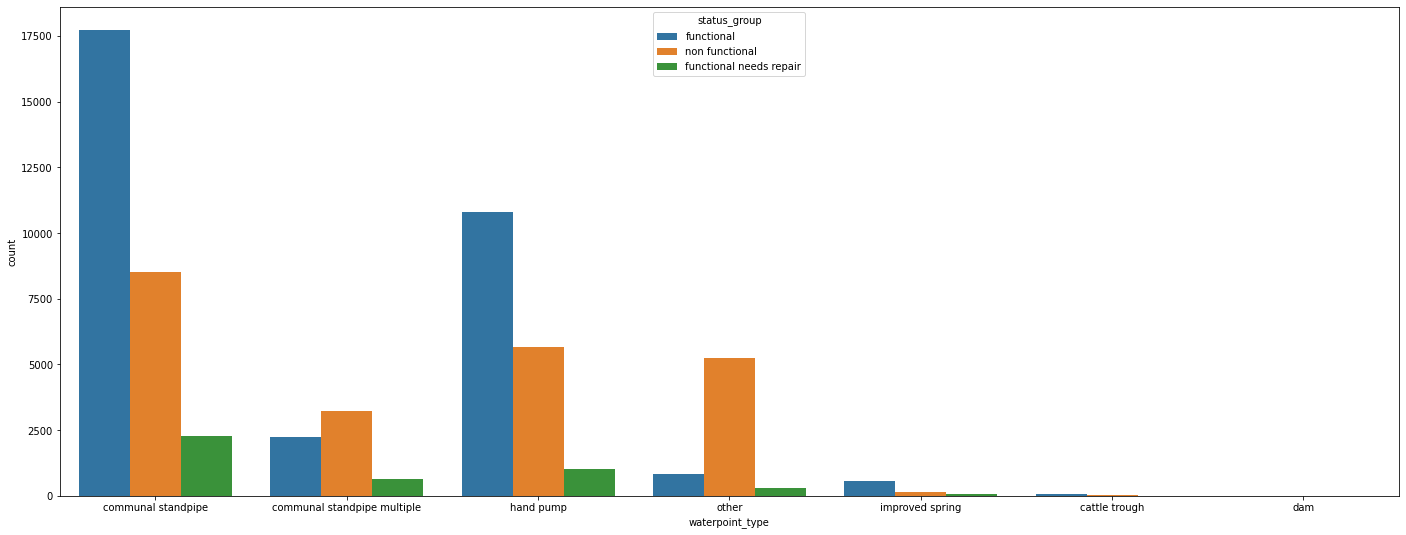

In [162]:
plt.figure(figsize=(24, 9))

sns.countplot(data=data,x='waterpoint_type',hue='status_group')

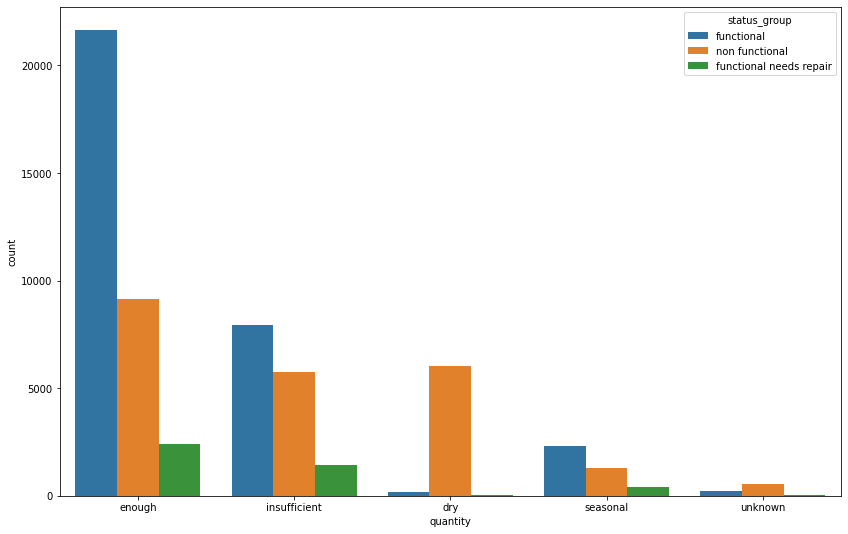

In [163]:
plt.figure(figsize=(14, 9))

sns.countplot(data=data,x='quantity',hue='status_group')

In [164]:
data.groupby(['district_code', 'region','construction_year']).size() 

district_code  region     construction_year
0              Dodoma     0                     23
1              Arusha     0                      3
                          1980                   2
                          1990                  23
                          2000                 137
                                              ... 
63             Mtwara     2011                   2
                          2012                   8
               Pwani      0                     37
67             Pwani      0                      6
80             Shinyanga  0                     12
Length: 2374, dtype: int64

In [166]:
data["latitude"].fillna(data.groupby(['region', 'district_code'])["latitude"].transform("mean"), inplace=True)
data["latitude"].fillna(data.groupby(['region'])["latitude"].transform("mean"), inplace=True)

In [168]:
data["latitude"].value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

In [ ]:
data["longitude"].fillna(data.groupby(['region', 'district_code'])["longitude"].transform("mean"), inplace=True)
data["longitude"].fillna(data.groupby(['region'])["longitude"].transform("mean"), inplace=True)

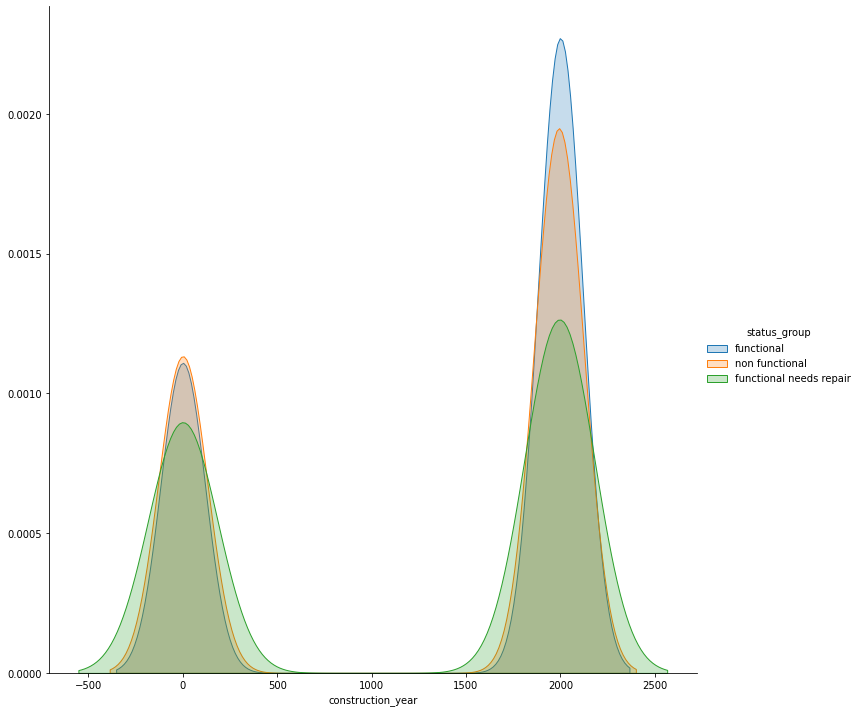

In [170]:
sns.FacetGrid(data, hue='status_group',height=10).map(sns.kdeplot, 'construction_year', shade=True).add_legend()

In [171]:
data['construction_year'].replace(0.0, np.nan, inplace=True)

In [172]:
data["construction_year"].fillna(data.groupby(['region', 'district_code'])["construction_year"].transform("median"), inplace=True)
data["construction_year"].fillna(data.groupby(['region'])["construction_year"].transform("median"), inplace=True)
data["construction_year"].fillna(data.groupby(['district_code'])["construction_year"].transform("median"), inplace=True)
data["construction_year"].fillna(data["construction_year"].median(), inplace=True)


if water point is old, it is highly likely to be non functional or needs repair.
### New features were created namely number of days and number of months water point is operational.

In [173]:
data['date_recorded'] = pd.to_datetime(data['date_recorded'])
data['operational_year'] = data.date_recorded.dt.year - data.construction_year

In [174]:
data['operational_month'] = data['operational_year']*12

In [175]:
data["recorded_year"] =data.date_recorded.dt.year

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: recorded_year, dtype: int64

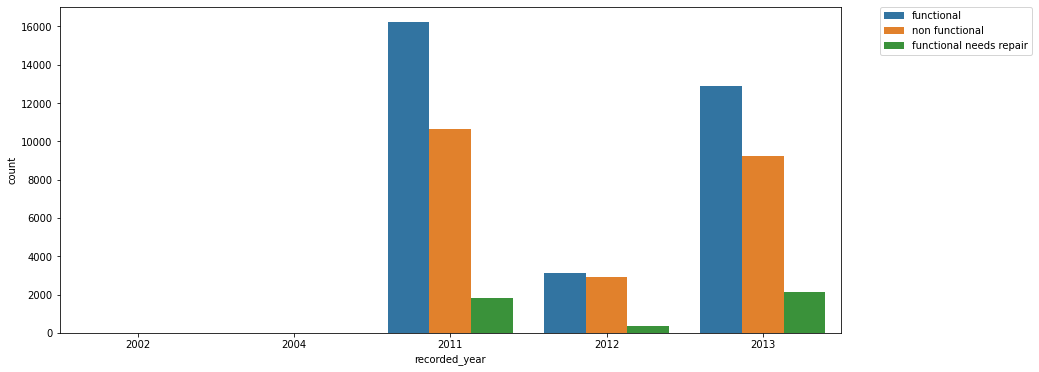

In [176]:
plt.figure(figsize=(14,6))
sns.countplot(data=data,x='recorded_year',hue='status_group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
data.recorded_year.value_counts()

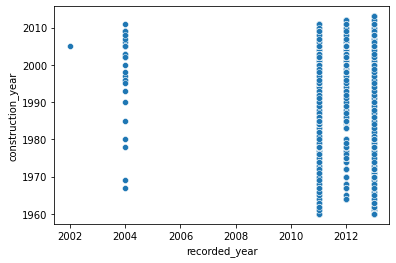

In [177]:
sns.scatterplot(data=data, x="recorded_year", y="construction_year")

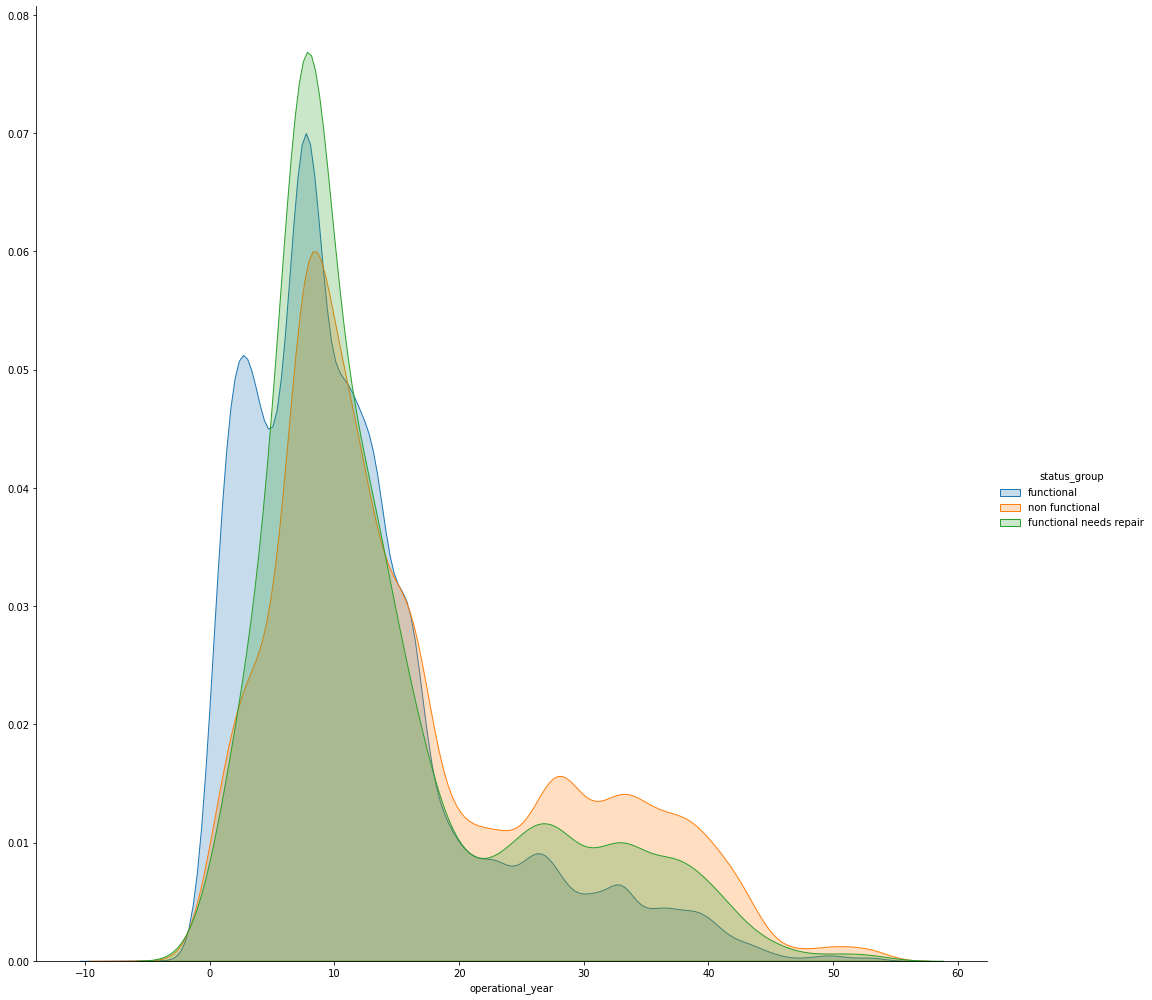

In [178]:
sns.FacetGrid(data, hue='status_group',height=14).map(sns.kdeplot, 'operational_year', shade=True).add_legend()

In [179]:
col_drop.append("date_recorded")

In [180]:
data.groupby(['payment', 'payment_type']).size() 

payment                payment_type
never pay              never pay       25348
other                  other            1054
pay annually           annually         3642
pay monthly            monthly          8300
pay per bucket         per bucket       8985
pay when scheme fails  on failure       3914
unknown                unknown          8157
dtype: int64

In [181]:
col_drop.append("payment")

In [182]:
print(data.groupby(['extraction_type_group','extraction_type_class','extraction_type']).size()   )   

extraction_type_group  extraction_type_class  extraction_type          
afridev                handpump               afridev                       1770
gravity                gravity                gravity                      26780
india mark ii          handpump               india mark ii                 2400
india mark iii         handpump               india mark iii                  98
mono                   motorpump              mono                          2865
nira/tanira            handpump               nira/tanira                   8154
other                  other                  other                         6430
other handpump         handpump               other - mkulima/shinyanga        2
                                              other - play pump               85
                                              other - swn 81                 229
                                              walimi                          48
other motorpump        motorpump     

In [183]:
col_drop.append("extraction_type_group")
col_drop.append("extraction_type_class")

In [184]:
print(data.groupby(['management', 'management_group']).size() )

management        management_group
company           commercial            685
other             other                 844
other - school    other                  99
parastatal        parastatal           1768
private operator  commercial           1971
trust             commercial             78
unknown           unknown               561
vwc               user-group          40507
water authority   commercial            904
water board       user-group           2933
wua               user-group           2535
wug               user-group           6515
dtype: int64


In [185]:
col_drop.append("management_group")

In [186]:
data.groupby(['water_quality', 'quality_group']).size() 

water_quality       quality_group
coloured            colored            490
fluoride            fluoride           200
fluoride abandoned  fluoride            17
milky               milky              804
salty               salty             4856
salty abandoned     salty              339
soft                good             50818
unknown             unknown           1876
dtype: int64

In [187]:
col_drop.append("quality_group")

In [188]:
data.groupby(['quantity', 'quantity_group']).size() 

quantity      quantity_group
dry           dry                6246
enough        enough            33186
insufficient  insufficient      15129
seasonal      seasonal           4050
unknown       unknown             789
dtype: int64

In [189]:
col_drop.append("quantity_group")

In [190]:
data.groupby(['source', 'source_type', 'source_class']).size() 

source                source_type           source_class
dam                   dam                   surface           656
hand dtw              borehole              groundwater       874
lake                  river/lake            surface           765
machine dbh           borehole              groundwater     11075
other                 other                 unknown           212
rainwater harvesting  rainwater harvesting  surface          2295
river                 river/lake            surface          9612
shallow well          shallow well          groundwater     16824
spring                spring                groundwater     17021
unknown               other                 unknown            66
dtype: int64

In [191]:
col_drop.append("source_type")
col_drop.append("source_class")

In [ ]:
.to_frame(name='counts').query('counts > 0')

In [194]:
data["funder"].fillna("other", inplace=True)
data["scheme_management"].fillna("other", inplace=True)
data["installer"].fillna("other", inplace=True)

print(data.isnull().sum().to_frame(name='counts').query('counts > 0'))

                counts
longitude         1812
subvillage         371
public_meeting    3334
scheme_name      28166
permit            3056


In [199]:
data.funder.value_counts().to_frame(name='counts').query('counts >30')

,counts
Government Of Tanzania,9084
other,3635
Danida,3114
Hesawa,2202
Rwssp,1374
...,...
Tuwasa,32
Kiuma,32
Kanisa Katoliki Lolovoni,31
The Desk And Chair Foundat,31


In [200]:
frequencies = data.funder.value_counts(normalize=True, ascending=True)
threshold = frequencies[(frequencies.cumsum() > 0.1).idxmax()]

In [206]:
data['funder']=data['funder'].mask(data['funder'].map(data['funder'].value_counts(normalize=True)) < threshold, 'Other')

In [ ]:
# # remove other unrelated features 
# col_drop.append("wpt_name")
# col_drop.append("num_private")
col_drop.append("subvillage")
# col_drop.append("region_code")
# col_drop.append("recorded_by")
# col_drop.append("public_meeting")
# col_drop.append("permit")
# col_drop.append("waterpoint_type_group")

In [ ]:
# col_drop.append("funder")

In [207]:
col_drop

['waterpoint_type_group',
 'installer',
 'scheme_name',
 'date_recorded',
 'payment',
 'extraction_type_group',
 'extraction_type_class',
 'management_group',
 'quality_group',
 'quantity_group',
 'source_type',
 'source_class']

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 59400 non-null  object        
 4   gps_height             59400 non-null  float64       
 5   installer              59400 non-null  object        
 6   longitude              57588 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

## Experimenting with the dataTraining

In [ ]:
# obj_column = data.columns[data.dtypes == "object"].values

In [ ]:
# obj_column

array(['basin', 'region', 'scheme_management', 'extraction_type',
       'management', 'payment_type', 'water_quality', 'quantity',
       'source', 'waterpoint_type', 'status_group'], dtype=object)

In [ ]:
# for i in obj_column:
#   print(i,":",data[i].unique(),)

In [ ]:
# categorical_encoding={ 
#     "basin" : ['Lake Nyasa' ,'Lake Victoria' ,'Pangani', 'Ruvuma / Southern Coast','Internal' ,'Lake Tanganyika' ,'Wami / Ruvu' ,'Rufiji' ,'Lake Rukwa']
#     ,"region" : ['Iringa', 'Mara', 'Manyara', 'Mtwara' ,'Kagera', 'Tanga' ,'Shinyanga' ,'Tabora','Pwani', 'Ruvuma' ,'Kilimanjaro', 'Rukwa' ,'Mwanza' ,'Kigoma', 'Lindi' ,'Dodoma','Arusha', 'Mbeya' ,'Singida' ,'Morogoro', 'Dar es Salaam']
#     ,"scheme_management" : ['VWC', 'Other', 'other' ,'Private operator', 'WUG', 'Water Board', 'WUA','Water authority', 'Company' ,'Parastatal', 'Trust', 'SWC' ,'None']
#     ,"extraction_type" : ['gravity' ,'submersible', 'swn 80', 'nira/tanira' ,'india mark ii', 'other','ksb' ,'mono' ,'windmill' ,'afridev' ,'other - rope pump', 'india mark iii', 'other - swn 81' ,'other - play pump' ,'cemo', 'climax' ,'walimi','other - mkulima/shinyanga']
#     ,"management" : ['vwc' ,'wug' ,'other' ,'private operator' ,'water board' ,'wua', 'company','water authority', 'parastatal' ,'unknown' ,'other - school', 'trust']
#     ,"payment_type" : ['annually' ,'never pay', 'per bucket', 'unknown' ,'on failure', 'other','monthly']
#     ,"water_quality" : ['soft', 'salty', 'milky' ,'unknown', 'fluoride', 'coloured' ,'salty abandoned','fluoride abandoned']
#     ,"quantity" : ['enough', 'insufficient', 'dry' ,'seasonal' ,'unknown']
#     ,"source" : ['spring' ,'rainwater harvesting' ,'dam' ,'machine dbh', 'other','shallow well', 'river' ,'hand dtw' ,'lake' ,'unknown']
#     ,"waterpoint_type" : ['communal standpipe' ,'communal standpipe multiple', 'hand pump', 'other','improved spring', 'cattle trough' ,'dam']
#     ,"status_group" : ['functional' ,'non functional' ,'functional needs repair']
# }

In [ ]:
# # mask out upper triangle
# mask = np.zeros_like(df[features].corr(), dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# plt.figure(figsize=(30,30))
# sns.heatmap(df[features].corr()*100, 
#            cmap='RdBu_r', 
#            annot = True, 
#            mask = mask
#             )

In [ ]:
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# # for i in obj_column:
# #   print(i,)
# #   le = preprocessing.LabelEncoder()
# #   le.fit(categorical_encoding[i])
# #   data[i]=le.transform(data[i])

In [ ]:
# data.drop(columns=col_drop,inplace=True)

In [ ]:
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
#  X_train, X_val, y_train, y_val = train_test_split(
#     data.drop(columns=["status_group","id"]),
#     data["status_group"],
#     test_size=0.3,
#     shuffle=True,
#     stratify=data["status_group"],
#     random_state=45)

Optimal number of features : 86


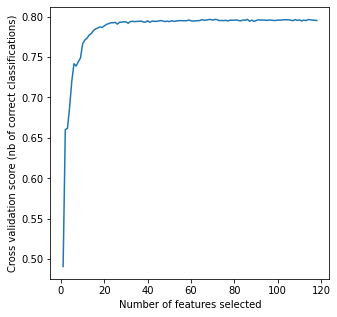

In [52]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold
# # from sklearn.datasets import make_classification
# # from sklearn import discriminant_analysis

# clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=9,max_depth=50,class_weight='balanced')
# rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
# rfecv.fit(X_train[featurs], y_train)

# print("Optimal number of features : %d" % rfecv.n_features_)

# plt.figure(figsize=(5,5))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [53]:
# rfecv.grid_scores_

array([0.49098124, 0.66024531, 0.66176046, 0.68816739, 0.72032227,
       0.74177489, 0.73888889, 0.74432419, 0.7487494 , 0.76635402,
       0.77101972, 0.77323232, 0.77727273, 0.77910053, 0.78280423,
       0.78482443, 0.78595479, 0.78730159, 0.78662819, 0.78862434,
       0.79037999, 0.79141414, 0.79242424, 0.79237614, 0.79297739,
       0.79078884, 0.79297739, 0.79316979, 0.79369889, 0.79357864,
       0.79184704, 0.79389129, 0.79427609, 0.79379509, 0.79413179,
       0.79422799, 0.79454064, 0.79341029, 0.79319384, 0.79494949,
       0.79292929, 0.79454064, 0.79420394, 0.79417989, 0.79456469,
       0.79516595, 0.79456469, 0.79389129, 0.79444444, 0.79386724,
       0.79492544, 0.79427609, 0.79449254, 0.79497354, 0.7950938 ,
       0.79497354, 0.79502165, 0.79487734, 0.79593555, 0.79478114,
       0.79454064, 0.79478114, 0.7950457 , 0.79511785, 0.79627225,
       0.79564695, 0.795671  , 0.7963444 , 0.7965368 , 0.79569505,
       0.79656085, 0.7962963 , 0.7951419 , 0.7952381 , 0.79516

In [54]:
# rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False, False,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True, False,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True])

In [55]:
# rfecv.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 16,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 33, 10,  1,  6, 28, 23,  1,  1,  1,  1,  1,  1,
        1, 24, 29,  1,  1, 17,  1,  1,  1,  1, 32, 26, 13, 14,  1,  1, 22,
       21,  1,  3, 27,  1,  1, 18, 11,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  7, 15, 30,  9,  1,  8,  1,  1,  1,  1,  1,  1,  1,  4,
       12,  5,  1, 20,  1,  1,  1,  1, 25, 19,  1,  1, 31,  1,  1,  1])

In [56]:
# rfecv_features=X_train.columns.values[rfecv.support_]
# rfecv_features

array(['amount_tsh', 'gps_height', 'longitude', 'latitude',
       'district_code', 'population', 'construction_year',
       'operational_year', 'basin_Internal', 'basin_Lake Nyasa',
       'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'region_Arusha', 'region_Dodoma',
       'region_Iringa', 'region_Kagera', 'region_Kigoma',
       'region_Kilimanjaro', 'region_Manyara', 'region_Mara',
       'region_Mbeya', 'region_Morogoro', 'region_Mtwara',
       'region_Mwanza', 'region_Pwani', 'region_Rukwa', 'region_Ruvuma',
       'region_Shinyanga', 'region_Singida', 'region_Tabora',
       'region_Tanga', 'scheme_management_Company',
       'scheme_management_Parastatal', 'scheme_management_VWC',
       'scheme_management_WUA', 'scheme_management_WUG',
       'scheme_management_Water Board',
       'scheme_management_Water authority', 'scheme_management_other',
       '

In [57]:
# y_pred=rfecv.estimator_.predict(X_val[rfecv_features])
# d=compute_metrics(y_pred,y_val)
# d

{'accuracy': 0.7970819304152638, 'confusiton_mat': array([[8446,  366,  866],
        [ 626,  466,  203],
        [1423,  132, 5292]]), 'f1': array([0.83735686, 0.41257193, 0.80133253]), 'precision': array([0.80476417, 0.48340249, 0.83194466]), 'recall': array([0.87270097, 0.35984556, 0.77289324])}

In [41]:
# print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu'))  # correct
# print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy']))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu
0.805	0.483	0.873	0.360	0.837	0.413	0.797


In [ ]:
# test_df["status_group"]=rfecv.estimator_.predict(test_df[rfecv_features])

In [ ]:
# test_df=test_df[["id","status_group"]]

In [ ]:
# test_df["status_group"]=le.inverse_transform(test_df["status_group"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# test_df["status_group"].value_counts()

functional                 8746
non functional             5375
functional needs repair     729
Name: status_group, dtype: int64

In [ ]:
# test_df.to_csv("submission1.csv",index=False)

#### try with diffenrent models

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score

In [ ]:
# classifiers=[['Logistic Regression :',LogisticRegression()],
#        ['Decision Tree Classification :',DecisionTreeClassifier()],
#        ['Gradient Boosting Classification :', GradientBoostingClassifier()],
#        ['Ada Boosting Classification :',AdaBoostClassifier()],
#        ['Extra Tree Classification :', ExtraTreesClassifier()],
#        ['K-Neighbors Classification :',KNeighborsClassifier()],
#        ['Support Vector Classification :',SVC()],
#        ['Gaussian Naive Bayes :',GaussianNB()]]
# cla_pred=[]
# models=[]

In [ ]:
# %%capture
# for name,model1 in classifiers:
#     print("-----------"+name+"-------------")
#     model1.fit(X_train[rfecv_features],y_train)
#     predicted_y = model1.predict(X_val[rfecv_features])
#     score=compute_metrics(predicted_y,y_val)
#     cla_pred.append(score)

In [ ]:
# #Prining the evaluation matrix to the console
# print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu'))  # correct
# for i in range(len(classifiers)):
#   # print("-----------"+classifiers[i][0]+"-------------")
#   d=cla_pred[i]
#   print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy']))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu
0.610	0.000	0.853	0.000	0.711	0.000	0.611
0.790	0.363	0.799	0.344	0.795	0.353	0.749
0.712	0.567	0.921	0.089	0.803	0.154	0.743
0.695	0.336	0.897	0.036	0.783	0.066	0.717
0.805	0.454	0.857	0.341	0.830	0.389	0.788
0.706	0.403	0.821	0.219	0.759	0.283	0.694
0.545	0.000	0.991	0.000	0.703	0.000	0.545
0.673	0.227	0.682	0.060	0.678	0.095	0.619
